#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import skimage
import matplotlib.pyplot as plt
import itertools
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

##**Normalizzazione**

In [ ]:
def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

##**Dataset**

In [ ]:
class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self._init_data()

    def _init_data(self):
        self.samples = []
        for i, trial in enumerate(self.trials):
            self.samples.append((trial, self.labels[i]))    
    
    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):

      return torch.tensor(_normalize_trial(self.trials[idx])), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
print(labels)

# **Splitting, Flatten and ML_Classification**

In [ ]:
from sklearn.model_selection import train_test_split

def split_subjs(trials, labels):
    if labels[0] == 0 and labels[112] == 1:
      #print('Sub Dispari')
      NONSOCIAL_RANGE = range(0,112)
      SOCIAL_RANGE = range(112,224)
      TRAIN_RANGE_S = range(0,79)
      TRAIN_RANGE_NONS = range(112,191)
      TEST_RANGE_S = range(79,101)
      TEST_RANGE_NONS = range(191,213)
      VAL_RANGE_S = range(101,112)
      VAL_RANGE_NONS = range(213,224)


      nonsoc_trials = []
      for nonsoc in NONSOCIAL_RANGE:
        nonsoc_trials.append(trials[nonsoc])
      seed = 42
      random.seed(seed)
      random.shuffle(nonsoc_trials)

      soc_trials = []
      for soc in SOCIAL_RANGE:
        soc_trials.append(trials[soc])
      seed = 42
      random.seed(seed)
      random.shuffle(soc_trials)

      trials = nonsoc_trials + soc_trials

      train_data = []
      train_labels = []
      for tns in TRAIN_RANGE_NONS:
        train_data.append(trials[tns])
        train_labels.append(labels[tns])
      for ts in TRAIN_RANGE_S:
        train_data.append(trials[ts])
        train_labels.append(labels[ts])

      test_data = []
      test_labels = []
      for tens in TEST_RANGE_NONS:
        test_data.append(trials[tens])
        test_labels.append(labels[tens])
      for tes in TEST_RANGE_S:
        test_data.append(trials[tes])
        test_labels.append(labels[tes])

      val_data = []
      val_labels = []
      for vns in VAL_RANGE_NONS:
        val_data.append(trials[vns])
        val_labels.append(labels[vns])
      for vs in VAL_RANGE_S:
        val_data.append(trials[vs])
        val_labels.append(labels[vs])

    # ----- PARI ---------

    if labels[0] == 1 and labels[112] == 0:
      #print('Sub Pari')
      SOCIAL_RANGE = range(0,112)
      NONSOCIAL_RANGE = range(112,224)

      TRAIN_RANGE_S = range(0,79)
      TRAIN_RANGE_NONS = range(112,191)

      TEST_RANGE_S = range(79,101)
      TEST_RANGE_NONS = range(191,213)

      VAL_RANGE_S = range(101,112)
      VAL_RANGE_NONS = range(213,224)


      soc_trials = []
      for soc in SOCIAL_RANGE:
        soc_trials.append(trials[soc])
      seed = 42
      random.seed(seed)
      random.shuffle(soc_trials)

      nonsoc_trials = []
      for nonsoc in NONSOCIAL_RANGE:
        nonsoc_trials.append(trials[nonsoc])
      seed = 42
      random.seed(seed)
      random.shuffle(nonsoc_trials)

      trials = soc_trials + nonsoc_trials

      train_data = []
      train_labels = []

      for ts in TRAIN_RANGE_S:
        train_data.append(trials[ts])
        train_labels.append(labels[ts])
      for tns in TRAIN_RANGE_NONS:
        train_data.append(trials[tns])
        train_labels.append(labels[tns])

      test_data = []
      test_labels = []


      for tes in TEST_RANGE_S:
        test_data.append(trials[tes])
        test_labels.append(labels[tes])
      for tens in TEST_RANGE_NONS:
        test_data.append(trials[tens])
        test_labels.append(labels[tens])

      val_data = []
      val_labels = []


      for vs in VAL_RANGE_S:
        val_data.append(trials[vs])
        val_labels.append(labels[vs])
      for vns in VAL_RANGE_NONS:
        val_data.append(trials[vns])
        val_labels.append(labels[vns])

    #print(f'Train Data Shape: ', np.shape(train_data))
    #print(f'Test Data Shape: ', np.shape(test_data))
    #print(f'Val Data Shape: ', np.shape(val_data))

    return train_data,train_labels, test_data, test_labels, val_data, val_labels

**Flatten per ML_Classifiers**




In [ ]:
def flatten(train_data, test_data, val_data):

    train_data = np.array(train_data)
    test_data = np.array(test_data)
    val_data = np.array(val_data)

    train_loop = range(0,158)
    test_loop = range(0,44)
    val_loop = range(0,22)

    #print(f'TRAIN PRIMA: ', np.shape(train_data))
    #print(f'TEST PRIMA: ', np.shape(test_data))
    #print(f'VAL PRIMA: ', np.shape(val_data))

    train_data_flatt = []
    test_data_flat = []
    test_data_flatt = []
    val_data_flatt = []
    

    for t in train_loop:
      train_data_flatt.append(train_data[t].flatten())

    for te in test_loop:
      test_data_flat.append(test_data[te].flatten())

    for v in val_loop:
      val_data_flatt.append(val_data[v].flatten())

    test_data_flatt = test_data_flat + val_data_flatt


    #print(f'TRAIN DOPO: ', np.shape(train_data_flatt))
    #print(f'TEST DOPO: ', np.shape(test_data_flatt))
    #print(f'VAL DOPO: ', np.shape(val_data_flatt))

    return train_data_flatt, test_data_flatt, val_data_flatt



In [ ]:
def ml_classification(train_data_flatt, train_labels, test_data_flatt):
    # --SVM--
    #Create a svm Classifier
    svm_clf = svm.SVC(kernel='rbf') # Linear Kernel

    #Train the model using the training sets
    svm_clf.fit(train_data_flatt, train_labels)

    #Predict the response for test dataset
    y_pred_svm = svm_clf.predict(test_data_flatt)

    # --RandomForest--

    rf_clf = RandomForestClassifier()

    rf_clf.fit(train_data_flatt, train_labels)

    y_pred_rf = rf_clf.predict(test_data_flatt)

     # --XGBoost--

    xgb_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)

    xgb_clf.fit(train_data_flatt, train_labels)

    y_pred_xgb = xgb_clf.predict(test_data_flatt)

    print('SVM of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_svm))
    print('RandomForest of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_rf))
    print('XGBoost of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_xgb))
    print('---------------------------------------------------------------')


'''
# --KNN--
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 100)

knn_clf.fit(train_data_flatt, train_labels)

y_pred_knn = knn_clf.predict(test_data_flatt)
'''

'\n# --KNN--\nfrom sklearn.neighbors import KNeighborsClassifier\nknn_clf = KNeighborsClassifier(n_neighbors = 100)\n\nknn_clf.fit(train_data_flatt, train_labels)\n\ny_pred_knn = knn_clf.predict(test_data_flatt)\n'

#**All Subjs**

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Tirocinio/Datasets/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, "sub-10/ProcessedData/data_ica.mat")
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
DATA = "ProcessedData/data_ica.mat"

In [ ]:
NUM_CHANNELS = 29
NUM_TRIAL = 224
TRIAL_RANGE = range(0, 224)
cueing_fase = range(1250,1750)

for s in SUBJECTS:
  if s == 'sub-02' or s == 'sub-07' or s == 'sub-36':
    continue
  else:
    curr_subj = (SUBJECTS_FOLDER + '/' + s + "/ProcessedData/data_ica.mat")
    mat = scipy.io.loadmat(curr_subj)
    trial = mat['trial']
    trialinfo = mat['trialinfo']
    trial = np.transpose(np.squeeze(trial))
    trials = []
    labels = []
    trials_norm = []
    for i, t in enumerate(trial):
      trials.append(t[ :NUM_CHANNELS, cueing_fase])
      labels.append(trialinfo[i, 5]-1)

    trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))

    #for tr in TRIAL_RANGE:
      #trials_norm.append(_normalize_trial(trials[tr]))

    train_data, train_labels, test_data, test_labels, val_data, val_labels = split_subjs(trials, labels)

    train_data_flatt, test_data_flatt, val_data_flatt = flatten(train_data, test_data, val_data)
    ml_classification(train_data_flatt, train_labels, test_data_flatt)



**XGBoost Only**

In [ ]:
def xgboost_classification(train_data_flatt, train_labels, test_data_flatt):

    xgb_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.0001, max_depth = 3, random_state = 0)

    xgb_clf.fit(train_data_flatt, train_labels)

    y_pred_xgb = xgb_clf.predict(test_data_flatt)

    print('XGBoost of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_xgb))
    print('---------------------------------------------------------------')

In [ ]:
NUM_CHANNELS = 29
NUM_TRIAL = 224
TRIAL_RANGE = range(0, 224)
cueing_fase = range(1250,1750)

for s in SUBJECTS:
  if s == 'sub-02' or s == 'sub-07' or s == 'sub-36':
    continue
  else:
    curr_subj = (SUBJECTS_FOLDER + '/' + s + "/ProcessedData/data_ica.mat")
    mat = scipy.io.loadmat(curr_subj)
    trial = mat['trial']
    trialinfo = mat['trialinfo']
    trial = np.transpose(np.squeeze(trial))
    trials = []
    labels = []
    trials_norm = []
    for i, t in enumerate(trial):
      trials.append(t[ :NUM_CHANNELS, cueing_fase])
      labels.append(trialinfo[i, 5]-1)

    trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))

    #for tr in TRIAL_RANGE:
      #trials_norm.append(_normalize_trial(trials[tr]))

    train_data, train_labels, test_data, test_labels, val_data, val_labels = split_subjs(trials, labels)

    train_data_flatt, test_data_flatt, val_data_flatt = flatten(train_data, test_data, val_data)
    xgboost_classification(train_data_flatt, train_labels, test_data_flatt)

XGBoost of sub-01:  0.5681818181818182
---------------------------------------------------------------
XGBoost of sub-03:  0.6136363636363636
---------------------------------------------------------------
XGBoost of sub-04:  0.4772727272727273
---------------------------------------------------------------
XGBoost of sub-05:  0.5681818181818182
---------------------------------------------------------------
XGBoost of sub-06:  0.5681818181818182
---------------------------------------------------------------
XGBoost of sub-09:  0.6363636363636364
---------------------------------------------------------------
XGBoost of sub-10:  0.5909090909090909
---------------------------------------------------------------
XGBoost of sub-11:  0.5909090909090909
---------------------------------------------------------------
XGBoost of sub-12:  0.5454545454545454
---------------------------------------------------------------
XGBoost of sub-13:  0.5227272727272727
----------------------------------

In [ ]:
print(f'Train Imbalance: ', train_labels.count(1)/len(train_labels))
print(f'Test Imbalance: ', test_labels.count(1)/len(test_labels))
print(f'Val Imbalance: ', val_labels.count(1)/len(val_labels))

In [ ]:


# Model Accuracy: how often is the classifier correct?
print("SVM: ", metrics.accuracy_score(test_labels, y_pred_svm))
print("RandomForest: ", metrics.accuracy_score(test_labels, y_pred_rf))


SVM:  0.7727272727272727
RandomForest:  0.8181818181818182
KNN:  0.5


In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)
test_dataset = EEG_dataset(test_data, test_labels)

#print(next(iter(train_dataset)))
#print(next(iter(val_dataset)))
#print(next(iter(test_dataset)))

In [ ]:
print(np.shape(train_dataset))

(158, 2)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [ ]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))
val_batch = next(iter(val_loader))
#print(train_batch)
print(type(train_batch))
print(f'Train batch type: ', type(train_batch[0]))
print(f'Test batch type: ', type(test_batch[0]))
print(f'Val batch type: ', type(val_batch[0]))
print(train_batch[0].shape)
train_batch[0] = torch.unsqueeze(train_batch[0], 0)
print(train_batch[0].shape)

<class 'list'>
Train batch type:  <class 'torch.Tensor'>
Test batch type:  <class 'torch.Tensor'>
Val batch type:  <class 'torch.Tensor'>
torch.Size([1, 125, 29])
torch.Size([1, 1, 125, 29])


In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

# Wavelet

In [ ]:
for t in range(NUM_TRIAL):
  trials[t], scales = cwt(trials[t], wavelet = 'morlet')
  trials[t] = abs(trials[t])

In [ ]:
print(f'Shape Trials[0]: ', trials[0].shape)
print()
#print(f'Trials Modulato: ',trials[0])

print(type(scales))
print(scales.shape)
print(scales)

#print(trials[0][253])
#print(type(trials[0]))
#print(type(scales))

Shape Trials[0]:  (254, 3625)

<class 'numpy.ndarray'>
(254,)
[3.83041310e+00 3.91428828e+00 4.00000000e+00 4.08758879e+00
 4.17709494e+00 4.26856184e+00 4.36203098e+00 4.45754719e+00
 4.55515432e+00 4.65489960e+00 4.75682831e+00 4.86098957e+00
 4.96743107e+00 5.07620382e+00 5.18735838e+00 5.30094671e+00
 5.41702223e+00 5.53563976e+00 5.65685415e+00 5.78072309e+00
 5.90730476e+00 6.03665781e+00 6.16884327e+00 6.30392361e+00
 6.44196129e+00 6.58302212e+00 6.72717142e+00 6.87447739e+00
 7.02500868e+00 7.17883635e+00 7.33603239e+00 7.49667072e+00
 7.66082621e+00 7.82857656e+00 8.00000000e+00 8.17517757e+00
 8.35418987e+00 8.53712368e+00 8.72406197e+00 8.91509438e+00
 9.11030865e+00 9.30979919e+00 9.51365662e+00 9.72197914e+00
 9.93486214e+00 1.01524076e+01 1.03747168e+01 1.06018934e+01
 1.08340445e+01 1.10712795e+01 1.13137083e+01 1.15614462e+01
 1.18146095e+01 1.20733156e+01 1.23376865e+01 1.26078472e+01
 1.28839226e+01 1.31660442e+01 1.34543428e+01 1.37489548e+01
 1.40500174e+01 1.43576

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


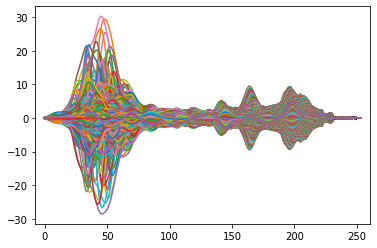

In [ ]:
plot(trials[1])

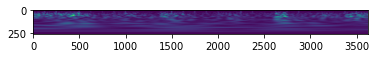

In [ ]:
plt.imshow(abs(trials[0]))

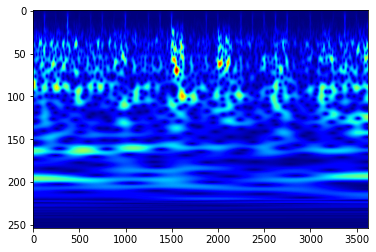

In [ ]:
cmap = plt.cm.jet
plt.imshow(trials[0], aspect='auto', cmap='jet')

In [ ]:
plt.plot(trials[0])

In [ ]:
cmap = plt.cm.jet
#trials[1] = abs(trials[1])

In [ ]:
print(f'{trials[0]}')

In [ ]:
print(labels[112])
print(labels[0])
print(trials[0])

# Saving images in train, test, val

Subs Dispari

In [ ]:

NONSOCIAL_RANGE = range(0,112)
SOCIAL_RANGE = range(112,224)

nonsoc_trials = []
for nonsoc in NONSOCIAL_RANGE:
  nonsoc_trials.append(trials[nonsoc])
random.shuffle(nonsoc_trials)

soc_trials = []
for soc in SOCIAL_RANGE:
  soc_trials.append(trials[soc])
random.shuffle(soc_trials)

trials = nonsoc_trials + soc_trials

TRAIN_RANGE_NONS = range(0,79)
TRAIN_RANGE_S = range(112,191)

TEST_RANGE_NONS = range(79,101)
TEST_RANGE_S = range(191,213)

VAL_RANGE_NONS = range(101,112)
VAL_RANGE_S = range(213,224)


Subs Pari

In [ ]:

SOCIAL_RANGE = range(0,112)
NONSOCIAL_RANGE = range(112,224)

soc_trials = []
for soc in SOCIAL_RANGE:
  soc_trials.append(trials[soc])
random.shuffle(soc_trials)

nonsoc_trials = []
for nonsoc in NONSOCIAL_RANGE:
  nonsoc_trials.append(trials[nonsoc])
random.shuffle(nonsoc_trials)

trials = soc_trials + nonsoc_trials

TRAIN_RANGE_S = range(0,79)
TRAIN_RANGE_NONS = range(112,191)

TEST_RANGE_S = range(79,101)
TEST_RANGE_NONS = range(191,213)

VAL_RANGE_S = range(101,112)
VAL_RANGE_NONS = range(213,224)


Single Subject


In [ ]:
for tns in TRAIN_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/train/nonsocial/trials_sub33_[' + str(tns) + '].png', trials[tns], cmap=cmap)

for ts in TRAIN_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/train/social/trials_sub33_[' + str(ts) + '].png', trials[ts], cmap=cmap)

for tens in TEST_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/test/nonsocial/trials_sub33_[' + str(tens) + '].png', trials[tens], cmap=cmap)

for tes in TEST_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/test/social/trials_sub33_[' + str(tes) + '].png', trials[tes], cmap=cmap)

for vns in VAL_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/val/nonsocial/trials_sub33_[' + str(vns) + '].png', trials[vns], cmap=cmap)

for vs in VAL_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/val/social/trials_sub33_[' + str(vs) + '].png', trials[vs], cmap=cmap)

All Subjects


In [ ]:
for tns in TRAIN_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/train/nonsocial/trials_sub33_[' + str(tns) + '].png', trials[tns], cmap=cmap)

for ts in TRAIN_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/train/social/trials_sub33_[' + str(ts) + '].png', trials[ts], cmap=cmap)

for tens in TEST_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/test/nonsocial/trials_sub33_[' + str(tens) + '].png', trials[tens], cmap=cmap)

for tes in TEST_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/test/social/trials_sub33_[' + str(tes) + '].png', trials[tes], cmap=cmap)

for vns in VAL_RANGE_NONS:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/val/nonsocial/trials_sub33_[' + str(vns) + '].png', trials[vns], cmap=cmap)

for vs in VAL_RANGE_S:
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/val/social/trials_sub33_[' + str(vs) + '].png', trials[vs], cmap=cmap)

# Checking number of files in train, test, val

In [ ]:
# folder path
train_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/train/nonsocial/'
train_social = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/train/social/'
test_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/test/nonsocial/'
test_social = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/test/social/'
val_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub33/val/nonsocial/'
val_social = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/subAll/val/social/'

num_of_files = 0
# Iterate directory
for path in os.listdir(train_nonsocial):
    # check if current path is a file
    if os.path.isfile(os.path.join(train_nonsocial, path)):
        num_of_files += 1
print('Train Non Social files', num_of_files)

num_of_files = 0
# Iterate directory
for path in os.listdir(train_social):
    # check if current path is a file
    if os.path.isfile(os.path.join(train_social, path)):
        num_of_files += 1
print('Train Social files', num_of_files)

num_of_files = 0
# Iterate directory
for path in os.listdir(test_nonsocial):
    # check if current path is a file
    if os.path.isfile(os.path.join(test_nonsocial, path)):
        num_of_files += 1
print('Test Non Social files', num_of_files)

num_of_files = 0
# Iterate directory
for path in os.listdir(test_social):
    # check if current path is a file
    if os.path.isfile(os.path.join(test_social, path)):
        num_of_files += 1
print('Test Social files', num_of_files)

num_of_files = 0
# Iterate directory
for path in os.listdir(val_nonsocial):
    # check if current path is a file
    if os.path.isfile(os.path.join(val_nonsocial, path)):
        num_of_files += 1
print('Val Non Social files', num_of_files)

num_of_files = 0
# Iterate directory
for path in os.listdir(val_social):
    # check if current path is a file
    if os.path.isfile(os.path.join(val_social, path)):
        num_of_files += 1
print('Val Social files', num_of_files)

Train Non Social files 3476
Train Social files 79
Test Non Social files 22
Test Social files 22
Val Non Social files 11
Val Social files 484


In [ ]:
for t in range(NUM_TRIAL):
  if(labels[t] == 0):
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Stick/trials[' + str(t) + '].png', trials[t], cmap=cmap)
  elif(labels[t] == 1):
    plt.imsave('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Avatar/trials[' + str(t) + '].png', trials[t], cmap=cmap)

In [ ]:
plt.savefig('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/trial[0].png', trials[0])

In [ ]:
plt.imshow(np.abs(trials[2]), aspect='auto', cmap='turbo')

In [ ]:
x = trials[2].real
y = trials[2].imag
plt.plot(x, y)

In [ ]:
print(trials[0].dtype)
trials[0] = abs(trials[0])
print(trials[0].dtype)

complex64
float32


In [ ]:
trials[1] = cv2.normalize(trials[1], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [ ]:
#trials[3] = np.clip(trials[3]*256,0, 255).astype(np.uint8)
trials[1] = cv2.cvtColor(trials[1],cv2.COLOR_GRAY2RGB)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/eli.png', abs(trials[0]))

True

In [ ]:
from PIL import Image, ImageDraw

im = Image.open(trials[0]).convert('RGBA')
iimg = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/' + trials[0] + '.png'
# Save result
im.save(iimg)

AttributeError: ignored

In [ ]:
a = np.array((1,2,3))
b = np.array((4,5,6))
m = [[[1,4,7],
     [2,5,8],
     [3,6,9],],
     [[10,13,16],
     [11,14,17],
     [12,15,18]]]
print(f'Matrix', m)

for idx_trial in range(2):
  new_col = []
  for idx_val in range(3):
    for idx,sub_list in enumerate(m[idx_trial]):
        new_col.append(sub_list[idx_val])
        print(f'M[] old: ',  m[idx_trial])
  m[idx_trial] = new_col

print(f'New_col', new_col)



print(f'Enumerate: ',list(enumerate(m)))
#print(np.vstack((m[0],m[1])))
print(f'M[0] new: ',  m[0])
print(f'M[1] new: ', m[1])
#print(m)
#print(m[0][0])

##**Normalizzazione**

In [ ]:
def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

##**Dataset**

In [ ]:
class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self._init_data()

    def _init_data(self):
        self.samples = []
        for i, trial in enumerate(self.trials):
            self.samples.append((trial, self.labels[i]))    
    
    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
      '''
      if self.labels[idx] == 3: #passive state
        label = torch.tensor(1, dtype=torch.long)
      else:
        label = torch.tensor(0, dtype=torch.long)
      '''
      return torch.tensor(_normalize_trial(self.trials[idx])), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
from sklearn.model_selection import train_test_split

seed = random.random()
random.seed(seed)
random.shuffle(trials)
random.seed(seed)
random.shuffle(labels)

train_data, val_data, train_labels, val_labels = train_test_split(trials, labels, test_size=0.30, random_state=42)

In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

In [ ]:
train_batch = next(iter(train_loader))
#print(train_batch)
print(type(train_batch))
print(type(train_batch[0]))
print(train_batch[0].shape)
train_batch[0] = torch.unsqueeze(train_batch[0], 0)
print(train_batch[0].shape)

<class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 254, 3625])
torch.Size([1, 1, 254, 3625])


In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

# **Training**

In [ ]:
plot_train_acc = []
plot_val_acc = []
plot_train_loss = []

def train_nn(model, train_loader, val_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0

  for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch + 1))
    model.train()
    curr_loss = 0.0
    curr_true = 0.0
    total = 0
    for batch in train_loader:
      #print(type(batch))
      trial, labels = batch
      #print('Labels --->', labels)
      #print('Labels type --->', type(labels))
      #print('Prima cambio -->  ', images.dtype)
      #images = images.type('torch.DoubleTensor') 
      #print('Dopo cambio -->  ', images.dtype)
      #images = torch.tensor(images)
      #labels = torch.tensor(labels)
      #images = images.to(device)
      #labels = labels.to(device)
      total += labels.size(0) #perche anche se il batch è da 32 l'ultimo potrebbe essere più piccolo

      optimizer.zero_grad()

      #print('Shape trial prima di passarle al model', np.shape(trial))
      #outputs = model(trial)
      #print('Outputs prima --->', outputs)
      outputs = model(trial.unsqueeze(1).float())
      #print('Outputs prima--->', np.shape(outputs))
      #print(type(outputs))

      predicted = torch.round(outputs) #l'1 specifica il one dimension reduce


      #print('Outputs -->', np.shape(outputs))
      #print('Labels -->', np.shape(labels))
      loss = criterion(outputs, labels.float())

      loss.backward()
        
      optimizer.step()

      curr_loss += loss.item()
      curr_true += (labels==predicted).sum().item()

    
    epoch_loss = curr_loss/len(train_loader)
    epoch_accuracy = (curr_true/total)*100
    plot_train_acc.append(epoch_accuracy)
    plot_train_loss.append(epoch_loss)
    #scheduler.step()

    print("   -- Training Dataset. Got %d out of %d trials correctly (%.3f%%). Epoch Loss: %.3f" %(curr_true, total, epoch_accuracy, epoch_loss))

    val_acc = evaluate_model_val(model, val_loader)
    plot_val_acc.append(val_acc)


    if(val_acc > best_acc):
      best_acc = val_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
      save_best_model(model)

  print("\n  -- Done!")
  return model


In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
      'comments': 'DatasetMixClahe SGD lr 0.001'
  }
  torch.save(state, 'checkpoint.pth.tar')

In [ ]:
def save_best_model(model):
  torch.save(model, 'best_model.pth.tar')

In [ ]:
def evaluate_model_val(model, val_loader):
  model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for batch in val_loader:
      trial, labels = batch
      trial = trial.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(trial.unsqueeze(1).float())

      predicted = torch.round(outputs)

      true_predicted_on_epoch += (predicted==labels).sum().item()

    epoch_accuracy = (true_predicted_on_epoch/total)*100

    print("   -- Val Dataset. Got %d out of %d trials correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))

  return epoch_accuracy

In [ ]:
num_classes = 2
NUM_CHANNELS = 29
device = set_device()
loss_fn = nn.BCELoss()

In [ ]:
from torch.nn.modules import dropout
class OurNet(nn.Module):

    def __init__(self):
        super(OurNet, self).__init__()
        torch.manual_seed(42)


        self.conv = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (3, 3), stride = 4);
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = None, padding = 0);
        self.batch = nn.BatchNorm1d(num_features = 8);
        self.act_f = nn.Hardshrink();
        #self.act_f = nn.GELU();
        self.drop = nn.Dropout(p = 0.4)
        self.lin = nn.Linear(in_features = 144, out_features = 320);
        self.drop1 = nn.Dropout(p = 0.3);
        #self.lstm = nn.LSTM(input_size = 128, hidden_size = 250)
        self.lstm = nn.GRU(input_size = 320, hidden_size = 350)

        self.lastlayer = nn.Linear(in_features = 350, out_features = 1);

    def forward(self, x):
        hidden = self.conv(x);
        print('Dopo conv --> ', hidden.size())
        #hidden = hidden.view(hidden.size()[0], -1)
        #hidden = torch.squeeze(hidden, dim = -1)
        print('Dopo squeeze --> ', hidden.size())
        hidden = self.pool(hidden)
        #print('Dopo MaxPool1D --> ', hidden.size())
        hidden = self.batch(hidden)
        #print('Dopo Batch --> ', hidden.size())
        hidden = self.act_f(hidden)
        hidden = self.drop(hidden)
        hidden = torch.flatten(hidden, start_dim = 1 , end_dim = -1)
        #print('Dopo Flatten --> ', hidden.size())
        hidden = self.lin(hidden)
        #print('Dopo lin --> ', hidden.size())
        hidden = self.drop1(hidden)
        hidden,_ = self.lstm(hidden)
        #print('Dopo LSTM --> ', np.shape(hidden))
        out = self.lastlayer(hidden)
        #print('Dopo ultimo Lin --> ',out.size())
        out = torch.squeeze(out, dim = -1)
        #print('Dopo squeeze --> ',out.size())
        #print()
        out = torch.sigmoid(out)

        return out

from torchvision import models
from torchsummary import summary

model = OurNet()
#summary(model, (1, 207, 22))

In [ ]:
summary(model,(1, 254, 3625))

Dopo conv -->  torch.Size([2, 6, 63, 906])
Dopo squeeze -->  torch.Size([2, 6, 63, 906])


ValueError: ignored

In [ ]:
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        torch.manual_seed(42)

        # Replace last layer
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (3,3), stride = 4);
        self.pool = nn.MaxPool2d(kernel_size=3, stride=None, padding=0)
        self.lin =  nn.Linear(in_features = 302, out_features = 252); #252x302
        self.act_f = nn.ReLU();
        self.drop = nn.Dropout(0.6);
        self.batch = nn.BatchNorm2d(6);
        self.lin1 = nn.Linear(in_features = 252,out_features = 14);
        #self.conv1 = nn.Conv2d(1,6, kernel_size=(16,NUM_CHANNELS), stride = 2);
        self.act_f1 = nn.ReLU();
        self.drop1 = nn.Dropout(0.6);
        self.batch1 = nn.BatchNorm2d(6);
        self.out = nn.Linear(in_features = 14,out_features = 1);
    
    def forward(self, x):
        hidden = self.conv(x);
        print('Dopo conv --> ',hidden.size())
        print('Dopo conv[0] --> ',hidden.size()[0])
        #hidden = hidden.view(hidden.size()[0], -1)
        #print('Dopo view --> ',hidden.size())
        hidden = self.pool(hidden)
        print('Dopo Pool --> ',hidden.size())
        hidden = self.lin(hidden);
        print('Dopo linear --> ',hidden.size())
        hidden = self.act_f(hidden);
        print('Dopo ReLU --> ',hidden.size())
        hidden = self.drop(hidden);
        hidden = self.batch(hidden);
        hidden = self.lin1(hidden);
        print('Dopo Lin1 --> ',hidden.size())
        #hidden = self.conv1(x);
        #print('Dopo Conv1 --> ',hidden.size())
        hidden = self.act_f1(hidden);
        hidden = self.drop1(hidden);
        hidden = self.batch1(hidden);
        out = self.out(hidden)
        print('Dopo ultimo Lin --> ', out.size())
        out = torch.squeeze(out, dim = 1)
        print('Dopo squeeze --> ', out.size())
        out = torch.sigmoid(out)

        return out

from torchvision import models
from torchsummary import summary

model = Net2()
#summary(model, (1, 207, 22))

In [ ]:
summary(model,(1, 254, 3625))

Dopo conv -->  torch.Size([2, 6, 63, 906])
Dopo conv[0] -->  2
Dopo Pool -->  torch.Size([2, 6, 21, 302])
Dopo linear -->  torch.Size([2, 6, 21, 252])
Dopo ReLU -->  torch.Size([2, 6, 21, 252])
Dopo Lin1 -->  torch.Size([2, 6, 21, 14])
Dopo ultimo Lin -->  torch.Size([2, 6, 21, 1])
Dopo squeeze -->  torch.Size([2, 6, 21, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6, 63, 906]              60
         MaxPool2d-2           [-1, 6, 21, 302]               0
            Linear-3           [-1, 6, 21, 252]          76,356
              ReLU-4           [-1, 6, 21, 252]               0
           Dropout-5           [-1, 6, 21, 252]               0
       BatchNorm2d-6           [-1, 6, 21, 252]              12
            Linear-7            [-1, 6, 21, 14]           3,542
              ReLU-8            [-1, 6, 21, 14]               0
           Dropout-9            

# Pre-Trained

In [ ]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
num_classes = 2
model.fc = nn.Linear(num_features, num_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
class PreNet(nn.Module):

    def __init__(self):
        super().__init__()

        # ResNet50
        self.network = model
        
        # Replace last layer
        self.network._fc = nn.Sequential(nn.Conv2d(2048,512,(3, 3)),
                                         nn.Linear(512, 128), 
                                         nn.ReLU(),
                                         nn.Dropout(0.4),
                                         nn.BatchNorm2d(128),
                                         nn.Linear(128, 32), 
                                         nn.ReLU(),  
                                         nn.Dropout(0.4),
                                         nn.BatchNorm2d(32),
                                         nn.Linear(32,num_classes))
    
    def forward(self, x):
        out = self.network(x)
        return out

model = PreNet()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003, dampening=0.1)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
optimizer = optim.Rprop(model.parameters(), lr=0.001)

In [ ]:
model = Net2()
train_nn(model, train_loader, val_loader, loss_fn, optimizer, 50)

Epoch number 1
Dopo conv -->  torch.Size([1, 6, 63, 906])
Dopo conv[0] -->  1
Dopo Pool -->  torch.Size([1, 6, 21, 302])
Dopo linear -->  torch.Size([1, 6, 21, 252])
Dopo ReLU -->  torch.Size([1, 6, 21, 252])
Dopo Lin1 -->  torch.Size([1, 6, 21, 14])
Dopo ultimo Lin -->  torch.Size([1, 6, 21, 1])
Dopo squeeze -->  torch.Size([1, 6, 21, 1])


ValueError: ignored

In [ ]:
checkpoint = torch.load('checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['comments'])

4
48.529411764705884
DatasetMixClahe SGD lr 0.001


In [ ]:
best_model = torch.load('best_model.pth.tar')

In [ ]:
all_pred = []
all_true = []
all_imgs = []

def evaluate_model_test(best_model, test_loader):

  best_model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()
  all_imgs = []
  all_true = []
  
  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for data in test_loader:
      images, labels = data

      for img in images:
        all_imgs.append(img) #mi salvo in una lista le immagini per ogni batch alla fine le avrò tutte
      for lab in labels:
        all_true.append(float(lab)) #mi salvo in una lista le labels per ogni batch alla fine le avrò tutte

      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)
     
      outputs = best_model(images)

      _, predicted = torch.max(outputs.data, 1)
      for pred in predicted:
        all_pred.append(float(pred)) #mi salvo tutte le prediction


      true_predicted_on_epoch += (predicted==labels).sum().item()
    
    epoch_accuracy = (true_predicted_on_epoch/total)*100
  print("   -- Test Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))
  precisionEval = metrics.precision_score(all_true, all_pred, zero_division=1)
  recallEval =  metrics.recall_score(all_true, all_pred, zero_division=1)
  f1Score = metrics.f1_score(all_true, all_pred, zero_division=1)
  print("   -- Test Dataset, precision: ", precisionEval)
  print("   -- Test Dataset, recall: ", recallEval)
  print("   -- Test Dataset, f1 score: ", f1Score)
  return epoch_accuracy

In [ ]:
test_acc = evaluate_model_test(best_model, test_loader)

In [ ]:
plt.plot(plot_train_acc, label = "Train Accuracy")
plt.plot(plot_val_acc, label = "Val Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(plot_train_loss, label = "Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(lrs, label = "Learning Rate")
plt.xlabel('time steps')
plt.ylabel('Lr')
plt.legend()
plt.show()


plotConfusions(all_true, all_pred)
print("Confusion matrixes plotted.")

In [ ]:
'''
mat = scipy.io.loadmat(CLA_PATH+FOLDERS_PATH)

NUM_CHANNELS = 29

ch_names = [item[0][0] for item in mat['o']['chnames'][0][0]]
ch_names = [mat['o']['chnames'][0][0][i][0][0] for i in range(NUM_CHANNELS-1)]
ch_names.append('X3')
#print(ch_names)

data = mat['o']['data'][0][0]
data_df = pd.DataFrame(data, columns=ch_names)
data_df.head()
'''

In [ ]:
'''
markers = list(mat['o']['marker'][0][0]) #labels
data = mat['o']['data'][0][0]
nS = int(mat['o']['nS'][0][0][0][0]) #number of samples

#markers = markers[0:60000]
nS = len(markers)
markers = list(filter(lambda marker: marker < 7 , markers))
n_labeled_S = int(len(markers)) #numero di label senza i 91-92-93 -> (0,1,2,3,4,5,6)

print(nS)
print(n_labeled_S)
'''

##**Trials extraction**

In [ ]:
'''
trials = []
labels = []
trial = []
for i in range(n_labeled_S-1):
  if markers[i] != 0:
    if markers[i+1] !=0: #trial
      trial.append(data[i, :])
    elif markers[i+1] == 0:
      trial.append(data[i, :])
      #trials.append(trial)
      trials.append(np.array(trial)[:203, :])
      labels.append(markers[i])
      trial = []

print(np.shape(np.array(trials[0])))
print('trial di zero', trials[0])
print(trials[0][0])
'''

##**Cerco la time_series più lunga così faccio padding a tutte le altre**

In [ ]:
'''
min_len = 207

for idx, trial in enumerate(trials):
 if((np.shape(np.array(trial))[0]) < min_len):
   min_len = np.shape(np.array(trial))[0]

print(min_len)
print(np.shape(np.array(trials[2])))
'''

##**Padding**

In [ ]:
'''
max_len = 207
padding = list(np.zeros(22))

for idx, trial in enumerate(trials):
  while (np.shape(np.array(trial))[0]) < max_len:
    trial.append(padding)
  list(trial)

print(np.shape(np.array(trials[43])))
'''

(207, 22)


In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, cnn, embed_size=1280, LSTM_UNITS=64, DO = 0.3):
        super(CNNLSTM, self).__init__()
        self.cnn = cnn.module
        self.cnn.eval()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

        self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global = nn.Linear(LSTM_UNITS*2, 9)

    def forward(self, x, lengths=None):
        with torch.no_grad():
            embedding = self.cnn.extract_features(x)
            embedding = self.avgpool(embedding)
            b,f,_,_ = embedding.shape
            embedding = embedding.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2

        output = self.linear_pe(hidden)
        output_global = self.linear_global(hidden.mean(1))
        return output,output_global